##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Adversarial Activation Atlas

This notebook uses  [**Lucid**](https://github.com/tensorflow/lucid) to reproduce the results in [Activation Atlas](https://distill.pub/2018/activation-atlas/).

This notebook doesn't introduce the abstractions behind lucid; you may wish to also read the [Lucid tutorial](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb).

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install and Imports

In [ ]:
!pip install --quiet "lucid>=0.3.11"
#!pip install --quiet --upgrade-strategy=only-if-needed git+https://github.com/tensorflow/lucid.git

In [3]:
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show, load, save

# for resizing images
from PIL import Image

# for image uploader
# from google.colab import files

# For plots
import matplotlib.pyplot as plt

In [4]:
model = models.InceptionV1()
model.load_graphdef()

In [5]:
def classify(image, n=10, show_output=True):
    im = Image.fromarray(np.uint8(image * 255.));
    im_resize = im.resize((224, 224), Image.LANCZOS)
    im_array = np.asarray(im_resize)/255.
    test_image = im_array[:,:,:3]
    tf.compat.v1.reset_default_graph()

    with tf.compat.v1.Session().as_default() as sess:
        input_t = tf.compat.v1.placeholder(tf.float32, shape=(224,224,3))
        model.import_graph(input_t)
        softmax2_t = sess.graph.get_tensor_by_name('import/softmax2:0')
        tf.compat.v1.global_variables_initializer().run()
        logits, = sess.run([softmax2_t], {input_t: test_image})

    BATCH = 0
    top_n_label_indices = np.argsort(logits)[BATCH][-n:][::-1]
    safe_top_n_label_indices = np.extract(top_n_label_indices < 1001, top_n_label_indices)
    top_n_labels = np.array(model.labels)[safe_top_n_label_indices]
    top_n_probs = logits[BATCH][safe_top_n_label_indices]
    max_length = max(len(label) for label in top_n_labels)
    predictions = ["{}: {: >6.2%}".format(label.rjust(max_length), prob) for (label, prob) in zip(top_n_labels, top_n_probs)]

    if show_output:
        show(test_image)
        print("\n".join(predictions))

    return (top_n_labels, top_n_probs)

In [6]:
# Takes two images and composites them
def composite_img(background_img, patch_img, patch_width_ratio=0.1, patch_position=(0.0, 0.0)):
    composite = background_img.copy()
    composite_img = Image.fromarray(np.uint8(composite * 255.))
    composite_img = composite_img.resize((224, 224), Image.LANCZOS)
    composite = (np.asarray(composite_img)/255.)[:,:,:3]

    if patch_width_ratio > 0:
        patch_img_width = int(patch_width_ratio * 224)
        patch_img_ = Image.fromarray(np.uint8(patch_img[:,:,:3] * 255.))
        patch_img_thumb = patch_img_.resize((patch_img_width, patch_img_width), Image.LANCZOS)
        patch_img_thumb_array = np.asarray(patch_img_thumb)/255.
        patch_img_thumb_size = patch_img_thumb_array.shape

        patch_y = int(patch_position[1] * (224 - patch_img_thumb_size[1]))
        patch_x = int(patch_position[0] * (224 - patch_img_thumb_size[0]))

        composite[patch_y:patch_y + patch_img_thumb_size[1], patch_x:patch_x + patch_img_thumb_size[0], 0:3] = patch_img_thumb_array

    composite_img = Image.fromarray(np.uint8(composite * 255.))
    composite_img_resize = composite_img.resize((224, 224), Image.LANCZOS)
    composite_img_resize_array = np.asarray(composite_img_resize)/255.
    return composite_img_resize_array

In [7]:
## If you want to upload an image from your desktop, uncomment and change this code,
## or use the left-side panel in colab to upload to the filesystem.
# uploaded = files.upload()
# f = list(uploaded.keys())[0]
# user_img = load(f)
# classify(user_img)

In [8]:
#snorkel_url = "https://storage.googleapis.com/lucid-static/activation-atlas/adversarial-examples/examples/snorkel.png"
#grey_whale_url = "https://storage.googleapis.com/lucid-static/activation-atlas/adversarial-examples/examples/grey-whale.jpg"
#frying_pan_url = "https://storage.googleapis.com/lucid-static/activation-atlas/adversarial-examples/examples/frying-pan.png"
snorkel_url = "https://github.com/ercaronte/lucid/raw/master/notebooks/static/snorkel.png"
grey_whale_url = "https://github.com/ercaronte/lucid/raw/master/notebooks/static/grey-whale.png"
frying_pan_url = "https://github.com/ercaronte/lucid/raw/master/notebooks/static/frying-pan.png"

## Snorkel


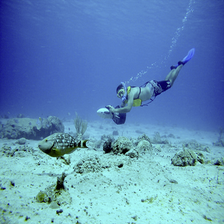

           snorkel: 55.60%
        coral reef: 18.65%
       scuba diver: 13.49%
        loggerhead:  5.52%
          lionfish:  1.71%
         sea snake:  1.36%
               ski:  0.43%
         rock crab:  0.40%
       rock beauty:  0.39%
leatherback turtle:  0.29%


In [9]:
background_img = load(snorkel_url)
_ = classify(background_img, n=10)


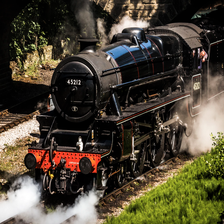

   steam locomotive: 100.00%
      passenger car:  0.00%
electric locomotive:  0.00%
            tractor:  0.00%
           thresher:  0.00%
        freight car:  0.00%
          harvester:  0.00%
               plow:  0.00%
    cannon [ground]:  0.00%
    football helmet:  0.00%


In [10]:
# Ten different patches are available, 01 - 10
#patch_img = load("https://storage.googleapis.com/lucid-static/activation-atlas/adversarial-examples/patches/train-10.png")
patch_img = load("https://github.com/ercaronte/lucid/raw/master/notebooks/static/train-10.png")
_ = classify(patch_img)


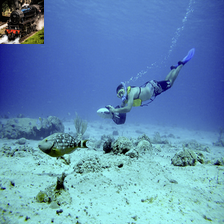

    snorkel: 51.47%
 coral reef: 20.41%
scuba diver: 16.00%
   lionfish:  3.60%
 loggerhead:  3.04%
  sea snake:  1.61%
rock beauty:  1.05%
        ski:  0.47%
     dugong:  0.25%
  rock crab:  0.20%


In [11]:
# a small patch doesn't effect the classification too much
small = composite_img(background_img, patch_img, patch_width_ratio=0.2, patch_position=(0.0, 0.0))
_ = classify(small)


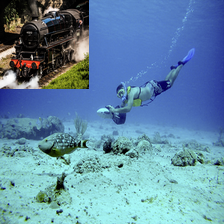

scuba diver: 70.99%
 coral reef: 14.87%
    snorkel:  4.51%
   lionfish:  3.28%
  sea snake:  2.42%
 loggerhead:  0.89%
rock beauty:  0.83%
     dugong:  0.39%
      wreck:  0.35%
        ski:  0.33%


In [12]:
# slightly bigger and it flips the top classification
medium = composite_img(background_img, patch_img, patch_width_ratio=0.4, patch_position=(0.0, 0.0))
_ = classify(medium)


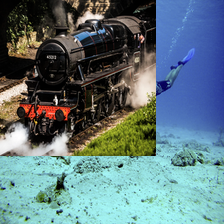

steam locomotive: 89.08%
        snowplow:  6.28%
            jeep:  0.77%
         tractor:  0.55%
     scuba diver:  0.52%
      snowmobile:  0.40%
   passenger car:  0.39%
            plow:  0.32%
       harvester:  0.18%
             alp:  0.12%


In [13]:
# Large patch overpowers the classification
small = composite_img(background_img, patch_img, patch_width_ratio=0.7, patch_position=(0., 0.))
_ = classify(small)

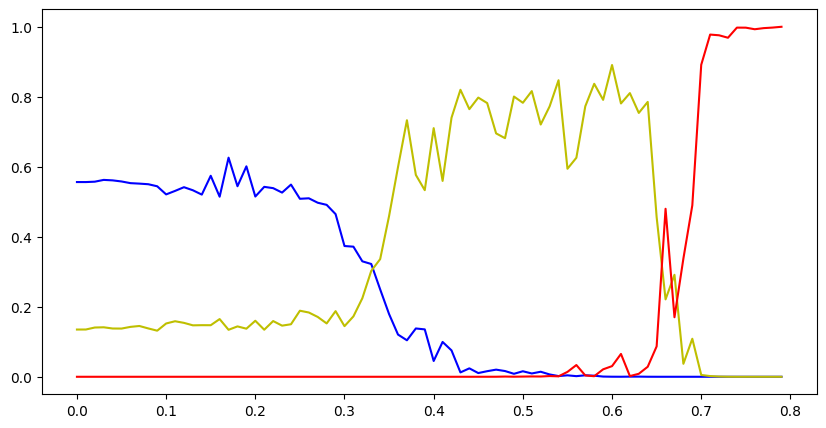

In [14]:
# Plotting different classifications at many different sizes

values = []
for i in range(80):
  size = i / 100.
  medium = composite_img(background_img, patch_img, size, (0, 0))
  _ = classify(medium, n=1008, show_output=False)
  scuba_index = _[0].tolist().index("snorkel")
  snorkel_index = _[0].tolist().index("scuba diver")
  target_index = _[0].tolist().index("steam locomotive")
  values.append([size, _[1][scuba_index], _[1][snorkel_index], _[1][target_index]])
values = np.array(values)

plt.figure(figsize=(10, 5))
plt.plot(values[:,0],values[:,1], c="b")
plt.plot(values[:,0],values[:,2], c="y")
plt.plot(values[:,0],values[:,3], c="r")
plt.show()

## Grey Whale


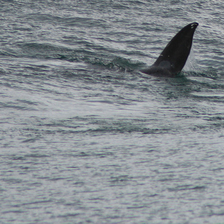

       grey whale: 90.95%
     killer whale:  7.54%
great white shark:  0.71%
              gar:  0.39%
         sea lion:  0.13%
      tiger shark:  0.07%
        albatross:  0.07%
           dugong:  0.04%
       hammerhead:  0.02%
            otter:  0.02%


In [15]:
grey_whale_img = load(grey_whale_url)
_ = classify(grey_whale_img, n=10)


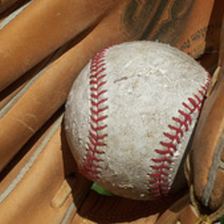

   baseball: 100.00%
 rugby ball:  0.00%
 cowboy hat:  0.00%
tennis ball:  0.00%
       drum:  0.00%
   sombrero:  0.00%
 ballplayer:  0.00%
  golf ball:  0.00%
French loaf:  0.00%
  armadillo:  0.00%


In [16]:
# Ten different patches are available, 01 - 10
baseball_patch = load("https://github.com/ercaronte/lucid/raw/master/notebooks/static/baseball-01.png")
_ = classify(baseball_patch, n=10)


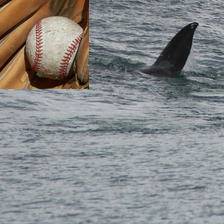

     great white shark: 68.19%
              baseball:  6.64%
            grey whale:  3.86%
              sombrero:  3.24%
              sea lion:  3.09%
          killer whale:  2.72%
             albatross:  1.60%
            rugby ball:  1.20%
               pelican:  1.13%
red-breasted merganser:  0.83%



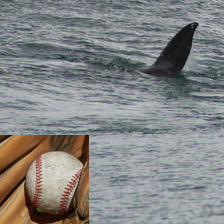

great white shark: 89.11%
         baseball:  8.82%
         sombrero:  0.48%
       grey whale:  0.33%
       cowboy hat:  0.25%
     killer whale:  0.22%
         sea lion:  0.09%
      tiger shark:  0.07%
       rugby ball:  0.06%
        albatross:  0.05%



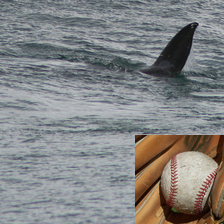

great white shark: 64.56%
         baseball: 26.14%
         sombrero:  2.57%
       cowboy hat:  0.95%
          thimble:  0.86%
       grey whale:  0.57%
              gar:  0.55%
        golf ball:  0.43%
       rugby ball:  0.24%
             drum:  0.23%



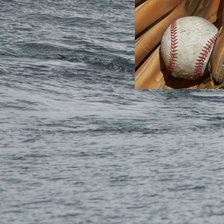

   baseball: 99.30%
 rugby ball:  0.32%
  golf ball:  0.11%
      conch:  0.08%
    thimble:  0.05%
 volleyball:  0.02%
bathing cap:  0.02%
tennis ball:  0.01%
   sombrero:  0.01%
  bottlecap:  0.01%


In [17]:
# Position does have an effect:
small = composite_img(grey_whale_img, baseball_patch, patch_width_ratio=0.4, patch_position=(0.0, 0.0))
_ = classify(small)
small = composite_img(grey_whale_img, baseball_patch, patch_width_ratio=0.4, patch_position=(0.0, 1.0))
_ = classify(small)
small = composite_img(grey_whale_img, baseball_patch, patch_width_ratio=0.4, patch_position=(1.0, 1.0))
_ = classify(small)
small = composite_img(grey_whale_img, baseball_patch, patch_width_ratio=0.4, patch_position=(1.0, 0.0))
_ = classify(small)

## Frying Pan


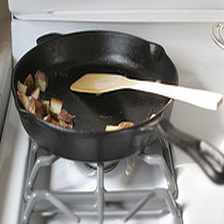

 frying pan: 76.52%
        wok: 15.83%
      stove:  5.41%
    spatula:  1.02%
 Dutch oven:  0.53%
mixing bowl:  0.17%
 rotisserie:  0.10%
      ladle:  0.10%
waffle iron:  0.09%
    hot pot:  0.06%


In [18]:
frying_pan_img = load(frying_pan_url)
_ = classify(frying_pan_img, n=10)


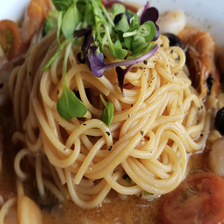

       carbonara: 99.09%
           plate:  0.47%
         hot pot:  0.11%
       soup bowl:  0.08%
hen-of-the-woods:  0.04%
       meat loaf:  0.04%
        broccoli:  0.04%
spaghetti squash:  0.03%
    head cabbage:  0.02%
butternut squash:  0.02%


In [19]:
# Ten different patches are available, 01 - 10
noodle_patch = load("https://github.com/ercaronte/lucid/raw/master/notebooks/static/noodles-03.png")
_ = classify(noodle_patch, n=10)


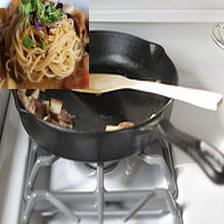

        wok: 66.35%
 frying pan: 28.01%
    hot pot:  2.12%
    spatula:  0.74%
  carbonara:  0.69%
      plate:  0.60%
      stove:  0.35%
mixing bowl:  0.24%
 Dutch oven:  0.22%
   strainer:  0.14%


In [20]:
# Position does have an effect:
small = composite_img(frying_pan_img, noodle_patch, patch_width_ratio=0.4, patch_position=(0.0, 0.0))
_ = classify(small)